
# **Optimisation de portfeuil**

## **Introduction**

Nous alons utiliser la methodologie *esperance-variance* pour optimiser deux portfeuils.

*   **Le premier :** un portfeuil qui contient un actif sans risque, et 5 actifs risqués avec le meilleur score **ESG** sur le **NASDAQ**.

*   **Le deuxieme :** un portfeuil qui contient un actif sans risque, et 5 actifs risqués avec le pire score **ESG** sur le **NASDAQ**


On prend également un troisième port feuil qui contient des entreprises avec beaucoup de liquidité pour comparer. 

In [3]:
from datetime import datetime
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import *
import scipy.integrate as integrate

In [6]:
from tvDatafeed import TvDatafeed, Interval

In [ ]:
!pip install tvDatafeed

In [7]:
logging.basicConfig(level=logging.DEBUG)

In [8]:
import time
import warnings
warnings.filterwarnings('ignore')

from selenium import webdriver
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
tv=TvDatafeed(auto_login=True, chromedriver_path="C:\webdrivers\chromedriver.exe")

In [ ]:
data_RF=tv.get_hist('GB01Y','TVC',Interval.in_1_hour,n_bars=5000)#,fut_contract=1)

## **Extraction des données**

Nous allons utiliser la bibliothèque  *tvDatafeed*

In [ ]:
#data_RF=tv.get_hist('GB01Y','TVC',Interval.in_1_hour,n_bars=5000)#,fut_contract=1)


asets=['FB','AMZN','NFLX','AAPL','GOOG']  
asets_C=['SATS','XRX','FOX','CMCSA','NWSA']
asets_A=['MSFT','JBHT','NVDA','QCOM','TXN']

markets=[]

dfs_name=['data_'+ast for ast in asets]
dfs_name_C=['data_'+ast for ast in asets_C]
dfs_name_A=['data_'+ast for ast in asets_A]

dfs_names=dfs_name.copy()
dfs_names.append('data_RF')

dfs_names_C=dfs_name_C.copy()
dfs_names_C.append('data_RF')

dfs_names_A=dfs_name_A.copy()
dfs_names_A.append('data_RF')



print(dfs_name)
i=0
for ast in asets_C:
  
  str = dfs_name_C[i]
  print(str)
  locals()[str] = tv.get_hist(ast,'NASDAQ',Interval.in_1_hour,n_bars=5000)#,fut_contract=1)
  i=i+1


j=0

for ast in asets_A:
  
  str = dfs_name_A[j]
  print(str)
  locals()[str] = tv.get_hist(ast,'NASDAQ',Interval.in_1_hour,n_bars=5000)#,fut_contract=1)
  j=j+1



t=0

for ast in asets:
  
  str = dfs_name[t]
  print(str)
  locals()[str] = tv.get_hist(ast,'NASDAQ',Interval.in_1_hour,n_bars=5000)#,fut_contract=1)
  t=t+1





## Traitement des données



In [12]:

def traitement_df(df):

  colums=['open',	'high',	'low',	'close',	'volume']

  for name in colums:
    col=df[name]
    
    dif_=[0]
    

    for i in range(1,len(col)):
      dif_.append((col[i]-col[i-1]))

    
    df[name+'log_dif']=df[name].pct_change().apply(lambda x: 100*np.log(1+x))


    df[name+'dif_']=np.array(dif_)
   
    df[name+'dif_abs']=np.abs(np.array(dif_))
    


    df[name+'_n']=np.array(df[name])/max(df[name])
  


 

In [13]:
for df_name in dfs_name_C+dfs_name_A+dfs_name:

  traitement_df(locals()[df_name])


traitement_df(data_RF)

In [14]:
for df_name in dfs_name_C+dfs_name_A+dfs_name:

  print(df_name,len(locals()[df_name]))

data_SATS 5000
data_XRX 5000
data_FOX 5000
data_CMCSA 5000
data_NWSA 5000
data_MSFT 5000
data_JBHT 5000
data_NVDA 5000
data_QCOM 5000
data_TXN 5000
data_FB 5000
data_AMZN 5000
data_NFLX 5000
data_AAPL 5000
data_GOOG 5000


In [15]:
def plotats(df,name,TS=False):
  col_n=name
  

  # for col_n in df.columns:

  #   print("################ " +col_n+" ###############")

  #   if col_n != 'symbol':

  if TS:
    df[col_n].plot()
  
  fig, ax = plt.subplots()



  sns.histplot(x=col_n, weights="volume", data=df, bins=150, ax=ax)
  
  warnings.filterwarnings('ignore')

  ax.set_xlabel(col_n)
  ax.set_ylabel("volume")

  plt.show()

  warnings.filterwarnings('ignore')

  plot_acf(df[col_n],lags=1,title='auto_cor_'+col_n)
  plt.show()
  warnings.filterwarnings('ignore')

  plot_pacf(df[col_n], lags=1,title='par_auto_cor_'+col_n)
  plt.show()
  warnings.filterwarnings('ignore')

      

    

## **Exploration des données**

On note $(t_i)_i$ la discrétisation du temps, et on défini
$$Z_i=P_i-P_{i-1}$$








On peut voir dans ce qui suit que $Z_1,....,Z_n$ sont independants

On estime la densite de $Z$ qui suit la même lois que l'échantillon en utilisant le noyau gaussien:
$$K(u)=\frac{1}{\sqrt{2\pi}}e^{-\frac{u^2}{2}}$$
 par: 
<!-- 
$$ \hat{f}_{n,h}(x_0)=\frac{1}{nh}\sum_{i=1}^nK\left(\frac{X_i-x_0}{h}\right $$  -->


$$\hat{f}_{n,h}(x_0)=\frac{1}{nh}\sum_{i=1}^nK\left(\frac{Z_i-x_0}{h}\right)$$

On a
$$MISE(\hat{f}_{n,h})=\mathbb{E}\left[ \int\hat{f}_{n,h}^2(x)\,dx -2\int \hat{f}_{n,h}(x)f(x)\,dx +\int f^2(x)\,dx\right]$$

On remarque alors que minimiser $ MISE $ en $ h $ revient à minimiser en h:
$$\mathcal{I}_h=\mathbb{E}\left[ \int\hat{f}_{n,h}^2(x)\,dx\right ] -2\mathbb{E}\left[\int \hat{f}_{n,h}(x)f(x)\,dx\right]$$
Par ailleur, $\int\hat{f}_{n,h}^2(x)\,dx$ est un éstimateur sans biais de $\mathbb{E}\left[ \int\hat{f}_{n,h}^2(x)\,dx\right ]$.

On va donc chercher un éstimateur sans biais de $\mathbb{E}\left[\int \hat{f}_{n,h}(x)f(x)\,dx\right]$, cela revient a chercher un éstimateur de $\mathbb{E}\left[ \hat{f}_{n,h}(Z)\right ]$, ou $Z$ est indépendant de $(Z_1,...,Z_n)$.

En effet,

$$\mathbb{E}_{_{(Z_1,...,Z_n)}}\left[\hat{f}_{n,h}(Z)\right]=\mathbb{E}_{_{(Z_1,...,Z_n)}}\left[\mathbb{E}_{_{Z}}[\hat{f}_{n,h}(Z)\mid Z_1,..,Z_n]\right]=\mathbb{E}_{_{(Z_1,...,Z_n)}}\left[\int \hat{f}_{n,h}(x)f(x)\,dx\right]$$
Vu que $\left(\hat{f}_{n,h}(Z_i)\right)_{i\leq n}$ ne sont pas i.i.d, on ne pourrais pas utiliser $\frac{1}{n}\sum_{i=1}^n\hat{f}_{n,h}(Z_i)$ comme éstimateur.

On va s'appuier sur le *leave-one-out* pour pallier à ce problème, on definit alors pour $i\in\{1,...,n\}$
$$\hat{f}_{n,h}^{(-i)}(x_0)=\frac{1}{(n-1)h}\sum_{j=1,j\neq i}^nK\left(\frac{Z_j-x_0}{h}\right)$$



On alors,
$$\mathbb{E}\left[\int \hat{f}_{n,h}(x)f(x)\,dx\right]=\mathbb{E}\left[\frac{1}{n}\sum_{i=1}^n\hat{f}_{n,h}^{(-i)}(Z_i)\right]$$
En effect $\left(\hat{f}_{n,h}^{(-i)}(Z_i)\right)_{i\leq n}$ sont i.i.d, donc $\mathbb{E}\left[\frac{1}{n}\sum_{i=1}^n\hat{f}_{n,h}^{(-i)}(Z_i)\right]=\mathbb{E}\left[\hat{f}_{n,h}^{(-1)}(Z_1)\right]$. 
D'une parts on a :

$$\mathbb{E}\left[\hat{f}_{n,h}^{(-1)}(Z_1)\right]=\mathbb{E}\left[\frac{1}{(n-1)h}\sum_{j=2}^nK\left(\frac{Z_j-Z_1}{h}\right)\right]=\frac{1}{h}\mathbb{E}\left[K\left(\frac{Z_2-Z_1}{h}\right)\right]$$

D'autre part,
$$\mathbb{E}\left[ \hat{f}_{n,h}(Z)\right ]=\mathbb{E}\left[\frac{1}{nh}\sum_{i=1}^nK\left(\frac{Z_i-Z}{h}\right)\right]=\frac{1}{h}\mathbb{E}\left[K\left(\frac{Z_1-Z}{h}\right)\right]$$
Donc,

$$\mathbb{E}\left[ \hat{f}_{n,h}(Z)\right ]=\mathbb{E}\left[\int \hat{f}_{n,h}(x)f(x)\,dx\right]=\mathbb{E}\left[\frac{1}{n}\sum_{i=1}^n\hat{f}_{n,h}^{(-i)}(Z_i)\right]$$
On abouti alors au critère pratique suivant:

$$\hat{h}\in \underset{h\geq0}{argmin}\left(\int\hat{f}_{n,h}^2(x)\,dx-\frac{2}{n}\sum_{i=1}^n\hat{f}_{n,h}^{(-i)}(Z_i)\right)$$

Si on défini :

$$L_i=ln(\frac{P_i}{P_{i-1}})=ln(P_i)-ln(P_{i-1})$$


alors si $r_{1,n}=\frac{P_n}{P_1}$ est le rendrement entre $t_1$ et $t_n$

$$
\begin{align*}
ln(r_{1,n})&=ln(\frac{P_n.}{P_1})=ln(\frac{\prod_{i=2}^{n-1}P_i. P_n}{\prod_{i=2}^{n-1}P_i.P_1})\\
&= ln(P_n)-ln(P_{1})  +\sum_{i=2}^{n-1} ln(P_i)-\sum_{i=3}^{n}ln(P_{i-1})\\
&=\sum_{i=2}^{n}ln(\frac{P_i}{P_{i-1}})=\sum_{i=2}^{n}L_i
\end{align*}$$

Donc 
$$r_{1,n}=exp(\sum_{i=2}^{n}L_i)$$


In [16]:
def noyau_gaussian(x):
  return( (1/sqrt(2*pi))*exp(-(x**2)/2)) 

In [ ]:
noyau_gaussian(10000)

0.0

In [17]:

def estimateur_noyau_gaussian(x_0,Dn,h):

  col=Dn
  sm=np.array([noyau_gaussian((col[i]-x_0)/h) for i in range(len(col))])
  return(np.mean(sm))




In [18]:
def distribution_plot(Df,name):
  
  D=np.array(Df[name])

  x_=np.linspace(min(D),max(D),5000)
  fx_=[estimateur_noyau_gaussian(x_[i],D[0:],5*np.std(D)/len(D))for i in range(len(x_))]

  plt.plot(x_,fx_)

  plt.show()
  warnings.filterwarnings('ignore')


In [53]:
data_AAPL.columns

Index(['symbol', 'open', 'high', 'low', 'close', 'volume', 'openlog_dif',
       'opendif_', 'opendif_abs', 'open_n', 'highlog_dif', 'highdif_',
       'highdif_abs', 'high_n', 'lowlog_dif', 'lowdif_', 'lowdif_abs', 'low_n',
       'closelog_dif', 'closedif_', 'closedif_abs', 'close_n', 'volumelog_dif',
       'volumedif_', 'volumedif_abs', 'volume_n'],
      dtype='object')

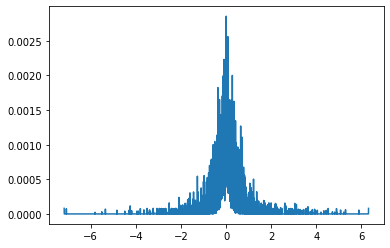

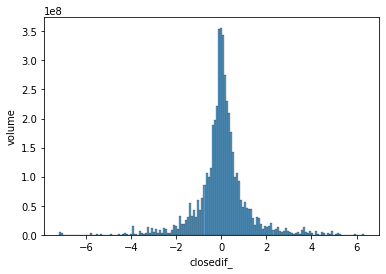

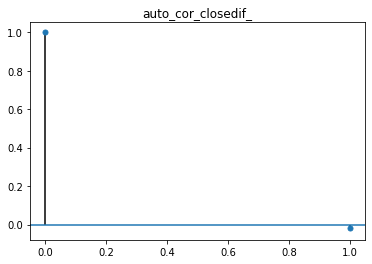

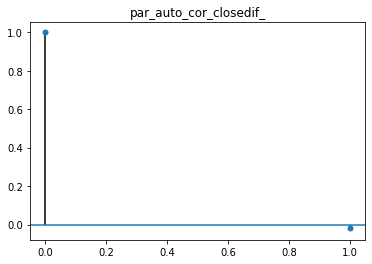

In [81]:
distribution_plot(data_AAPL,'closedif_')

plotats(data_AAPL,'closedif_')

In [19]:
por_foyo_c=pd.DataFrame(data_RF['close'])
for dfn in dfs_name_C:
  df=locals()[dfn].copy()
  #print(df['close'])
  por_foyo_c[dfn]=np.array(df['close'])




por_foyo_c=por_foyo_c.drop(columns='close')

In [29]:
por_foyo_c

,data_SATS,data_XRX,data_FOX,data_CMCSA,data_NWSA
datetime,,,,,
2020-10-21 17:00:00,31.802995,31.560,34.62,41.185,11.445
2020-10-21 22:00:00,31.932605,30.440,34.57,41.140,11.410
2020-10-21 23:00:00,31.851599,30.820,34.62,41.050,11.390
2020-10-22 05:00:00,32.507748,30.660,34.57,41.090,11.400
2020-10-22 06:00:00,32.783169,30.550,34.62,40.990,11.375
...,...,...,...,...,...
2022-04-01 13:00:00,24.800000,19.610,35.97,47.340,21.880
2022-04-01 14:00:00,24.600000,19.670,36.10,47.450,21.840
2022-04-01 15:00:00,24.890000,19.900,36.26,47.770,22.020


In [20]:
por_foyo_c

,data_SATS,data_XRX,data_FOX,data_CMCSA,data_NWSA
datetime,,,,,
2020-10-21 17:00:00,31.802995,31.560,34.62,41.185,11.445
2020-10-21 22:00:00,31.932605,30.440,34.57,41.140,11.410
2020-10-21 23:00:00,31.851599,30.820,34.62,41.050,11.390
2020-10-22 05:00:00,32.507748,30.660,34.57,41.090,11.400
2020-10-22 06:00:00,32.783169,30.550,34.62,40.990,11.375
...,...,...,...,...,...
2022-04-01 13:00:00,24.800000,19.610,35.97,47.340,21.880
2022-04-01 14:00:00,24.600000,19.670,36.10,47.450,21.840
2022-04-01 15:00:00,24.890000,19.900,36.26,47.770,22.020


In [21]:
por_foyo_a=pd.DataFrame(data_RF['close'])
for dfn in dfs_name_A:
  df=locals()[dfn].copy()
  #print(df['close'])
  por_foyo_a[dfn]=np.array(df['close'])
  
por_foyo_a=por_foyo_a.drop(columns='close')


In [22]:
por_foyo=pd.DataFrame(data_RF['close'])
for dfn in dfs_name:
  df=locals()[dfn].copy()
  #print(df['close'])
  por_foyo[dfn]=np.array(df['close'])


por_foyo=por_foyo.drop(columns='close')
  

In [23]:

import plotly.graph_objects as go

In [66]:
figc = go.Figure()
data_num_c = por_foyo_c.copy()#drop(columns = ["datetime"])
for col in data_num_c.columns:
    figc.add_trace(go.Box(x= data_num_c[col].values, name=data_num_c[col].name))
figc.show() 

figa = go.Figure()
data_num_a = por_foyo_a.copy()#drop(columns = ["datetime"])
for col in data_num_a.columns:
    figa.add_trace(go.Box(x= data_num_a[col].values, name=data_num_a[col].name))
figa.show() 


fig = go.Figure()
data_num = por_foyo.copy()#drop(columns = ["datetime"])
for col in data_num.columns:
    fig.add_trace(go.Box(x= data_num[col].values, name=data_num[col].name))
fig.show() 



In [24]:
pfl_c=por_foyo_c.pct_change().apply(lambda x: np.log(1+x))
pfl_a=por_foyo_a.pct_change().apply(lambda x: np.log(1+x))
pfl=por_foyo.pct_change().apply(lambda x: np.log(1+x))

In [25]:
cov_c=por_foyo_c.pct_change().cov().apply(lambda x: np.log(1+x)).cov()
cov_a=por_foyo_a.pct_change().cov().apply(lambda x: np.log(1+x)).cov()
cov=por_foyo.pct_change().cov().apply(lambda x: np.log(1+x)).cov()



In [26]:
cor_c=por_foyo_c.pct_change().cov().apply(lambda x: np.log(1+x)).corr()
cor_a=por_foyo_a.pct_change().cov().apply(lambda x: np.log(1+x)).corr()
cor=por_foyo.pct_change().cov().apply(lambda x: np.log(1+x)).corr()

In [27]:
print(pd.DataFrame(cov_c))
print(pd.DataFrame(cov_a))

               data_SATS      data_XRX      data_FOX    data_CMCSA  \
data_SATS   2.136120e-09 -7.399247e-10 -4.145991e-10 -3.119148e-10   
data_XRX   -7.399247e-10  3.538172e-09 -9.945502e-10 -1.522123e-10   
data_FOX   -4.145991e-10 -9.945502e-10  1.202915e-09 -3.320507e-10   
data_CMCSA -3.119148e-10 -1.522123e-10 -3.320507e-10  4.647571e-10   
data_NWSA  -3.815052e-10 -8.256248e-10  8.784476e-10 -3.886143e-10   

               data_NWSA  
data_SATS  -3.815052e-10  
data_XRX   -8.256248e-10  
data_FOX    8.784476e-10  
data_CMCSA -3.886143e-10  
data_NWSA   1.201704e-09  
              data_MSFT     data_JBHT     data_NVDA     data_QCOM  \
data_MSFT  3.917830e-10 -1.497335e-10 -2.952855e-10 -1.458065e-10   
data_JBHT -1.497335e-10  6.445756e-10 -4.406703e-10 -2.563499e-10   
data_NVDA -2.952855e-10 -4.406703e-10  3.383447e-09 -2.840056e-10   
data_QCOM -1.458065e-10 -2.563499e-10 -2.840056e-10  1.543762e-09   
data_TXN  -1.207080e-10 -1.953701e-10 -2.374502e-10 -2.483321e-10   

  

In [28]:
# cov
w = { 'data_FB': 1/5, 'data_AMZN': 1/5, 'data_NFLX': 1/5, 'data_AAPL':1/5,	'data_GOOG':1/5}
w_c={	'data_SATS':1/5,	'data_XRX':1/5,	'data_FOX':1/5,	'data_REYN':1/5,	'data_NWSA':1/5}
w_a={	'data_MSFT':1/5,	'data_JBHT':1/5,	'data_NVDA':1/5,	'data_QCOM':1/5	,'data_TXN':1/5}

port_var_c = cov_c.mul(w_c, axis=0).mul(w_c, axis=1).sum().sum()
port_var_a = cov_a.mul(w_a, axis=0).mul(w_c, axis=1).sum().sum()
port_var = cov.mul(w, axis=0).mul(w, axis=1).sum().sum()

In [29]:
print("Variance du potfeuil CCC : ",port_var_c)
print("Variance du potfeuil AAA : ",port_var_a)
print("Variance du potfeuil  : ",port_var)

Variance du potfeuil CCC :  1.2493589929064074e-10
Variance du potfeuil AAA :  0.0
Variance du potfeuil  :  4.868047220076496e-11


In [30]:
ind_er_c = por_foyo_c.pct_change().apply(lambda x: np.log(1+x)).fillna(method="backfill").replace([np.inf, -np.inf], 0).sum()

np.exp(ind_er_c)



data_SATS     0.796555
data_XRX      0.610613
data_FOX      1.043551
data_CMCSA    1.157166
data_NWSA     1.911132
dtype: float64

In [31]:
ind_er_a = por_foyo_a.pct_change().apply(lambda x: np.log(1+x)).fillna(method="backfill").replace([np.inf, -np.inf],[1,-1]).sum()
np.exp(ind_er_a)

data_MSFT    2.495032
data_JBHT    2.045871
data_NVDA    7.807298
data_QCOM    2.168440
data_TXN     1.712781
dtype: float64

In [32]:
ind_er = por_foyo.pct_change().apply(lambda x: np.log(1+x)).fillna(method="backfill").replace([np.inf, -np.inf], 0).sum()
np.exp(ind_er)

data_FB      1.255589
data_AMZN    1.824792
data_NFLX    1.073444
data_AAPL    3.962875
data_GOOG    2.537448
dtype: float64

In [33]:
wc_=[i for i in w_c.values()]
#w.values()
port_er_c = (wc_*ind_er_c).sum()
port_er_c=np.exp(port_er_c)
print("PF Ernigs CCC: ",port_er_c)


wa_=[i for i in w_a.values()]
#w.values()
port_er_a = (wa_*ind_er_a).sum()
port_er_a=np.exp(port_er_a)

print("PF Ernings AAA: ",port_er_a)

w_=[i for i in w.values()]
#w.values()
port_er= (w_*ind_er).sum()
port_er=np.exp(port_er)
print("PF Ernings : ",port_er)

PF Ernigs CCC:  1.0233786448914939
PF Ernings AAA:  2.7168200744971167
PF Ernings :  1.899544702130914


In [34]:
por_foyo_c_c=por_foyo_c.copy()
por_foyo_a_c=por_foyo_a.copy()
por_foyo__c=por_foyo.copy()

por_foyo__c['zero']=[1 for k in range(5000)]

por_foyo_a_c['PF']=1/5*(por_foyo_a['data_MSFT']+por_foyo_a['data_JBHT']+por_foyo_a['data_NVDA']+por_foyo_a['data_QCOM']+por_foyo_a['data_TXN'])
por_foyo_c_c['PF']=1/5*(por_foyo_c['data_SATS']+por_foyo_c['data_XRX']+por_foyo_c['data_FOX']+por_foyo_c['data_CMCSA']+por_foyo_c['data_NWSA'])
por_foyo__c['PF']=1/5*(por_foyo['data_FB']+por_foyo['data_AMZN']+por_foyo['data_NFLX']+por_foyo['data_AAPL']+por_foyo['data_GOOG'])

In [35]:
por_foyo_a_c['PFn']=por_foyo_a_c['PF']/por_foyo_a_c['PF'][0]#max(por_foyo_a_c['PF'])
por_foyo_c_c['PFn']=por_foyo_c_c['PF']/por_foyo_c_c['PF'][0]#max(por_foyo_c_c['PF'])
por_foyo__c['PFn']=por_foyo__c['PF']/por_foyo__c['PF'][0]#max(por_foyo__c['PF'])

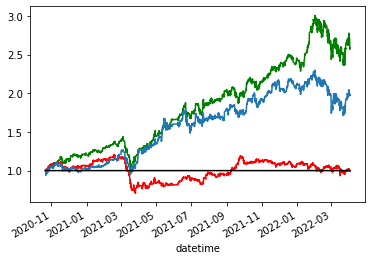

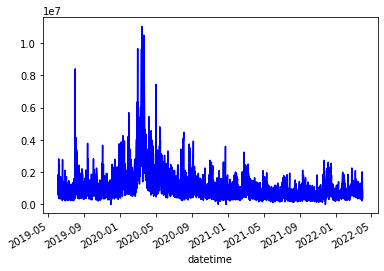

In [56]:
por_foyo_a_c['PFn'].plot(color='green')
por_foyo_c_c['PFn'].plot(color='red')
por_foyo__c['PFn'].plot()
por_foyo__c['zero'].plot(color='black')
plt.show()
warnings.filterwarnings('ignore')
data_AAPL['volume'].plot(color='blue')

warnings.filterwarnings('ignore')

## **frontière efficiente**


In [37]:
p_ret = [] 
p_vol = [] 
p_weights = [] 

num_assets = len(por_foyo_a.columns)
num_portfolios = 10000

In [47]:
num_assets

5

In [38]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er_a) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = cov.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd#*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

In [39]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(por_foyo.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]
portfolios  = pd.DataFrame(data)
portfolios.head()

,Returns,Volatility,data_FB weight,data_AMZN weight,data_NFLX weight,data_AAPL weight,data_GOOG weight
0,1.058659,0.000010,0.322637,0.119730,0.226308,0.146671,0.184654
1,1.036777,0.000009,0.073991,0.236724,0.241527,0.264427,0.183332
2,0.961962,0.000009,0.104469,0.282708,0.203661,0.107524,0.301638
3,1.070480,0.000010,0.372491,0.004434,0.222925,0.225894,0.174257
4,0.891939,0.000008,0.227618,0.287466,0.134874,0.053052,0.296990


In [43]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]

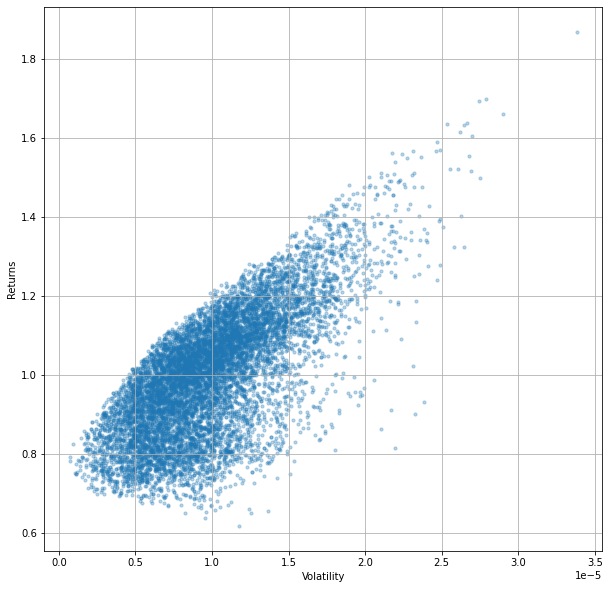

In [40]:
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])

In [53]:
rf = 1 # risk free factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns             1.561118
Volatility          0.000022
data_FB weight      0.153832
data_AMZN weight    0.006560
data_NFLX weight    0.599016
data_AAPL weight    0.234402
data_GOOG weight    0.006189
Name: 4145, dtype: float64

In [54]:
min_vol_port

Returns             7.921198e-01
Volatility          7.049543e-07
data_FB weight      1.337671e-01
data_AMZN weight    2.202114e-01
data_NFLX weight    6.667161e-02
data_AAPL weight    2.688160e-01
data_GOOG weight    3.105339e-01
Name: 3213, dtype: float64

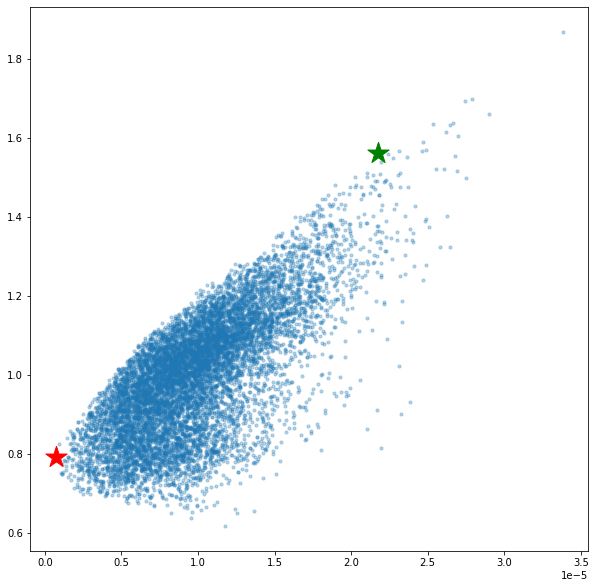

In [55]:
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)